In [1]:
import pandas as pd

# Load the dataset
file_path = '../data/raw_analyst_ratings.csv'  
df = pd.read_csv(file_path)

# Display the first few rows to ensure it's loaded correctly
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [2]:
import pandas as pd
print(pd.__version__)

2.2.2


In [3]:

def descriptive_statistics(df, headline_col=None, publisher_col=None, date_col=None):
    # Initialize results dictionary to store outputs
    results = {}
    
    # Handle missing columns
    if headline_col and headline_col in df.columns:
        # Efficient calculation of headline length using vectorized operations
        df['headline_length'] = df[headline_col].fillna('').str.len()
        results['headline_stats'] = df['headline_length'].describe()
    
    if publisher_col and publisher_col in df.columns:
        # Count articles per publisher
        results['articles_per_publisher'] = df[publisher_col].value_counts()
    
    if date_col and date_col in df.columns:
        # Parse dates only once, use pd.to_datetime for faster conversion
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        # Analyze publication trend over time
        results['trend_over_time'] = df[date_col].dt.date.value_counts().sort_index()

    return results

# Call the function and display results
stats = descriptive_statistics(df, headline_col='headline', publisher_col='publisher', date_col='date')
print(stats.get('headline_stats', 'No headline data'))
print(stats.get('articles_per_publisher', 'No publisher data'))
print(stats.get('trend_over_time', 'No date data'))

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64
date
2011-04-27      1
2011-04-28      2
2011-04-29      2
2011-04-30      1
2011-05-01      1
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    544
Name: count, Length: 2528, dtype: int64


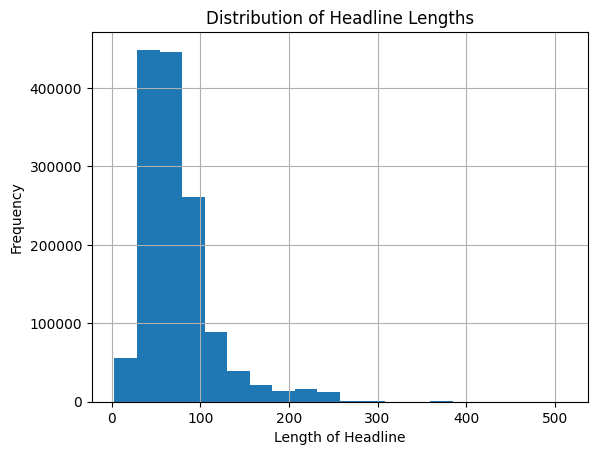

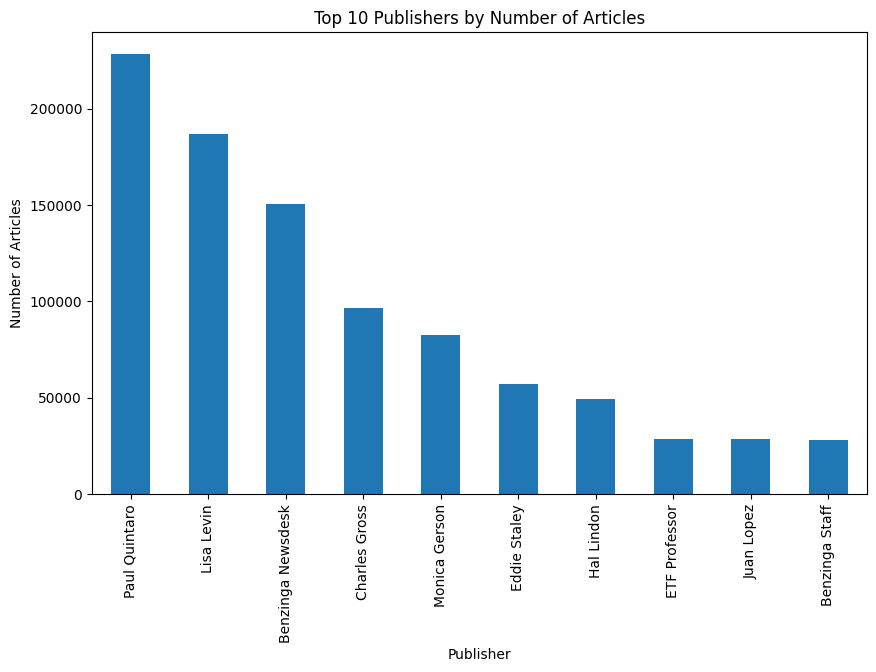

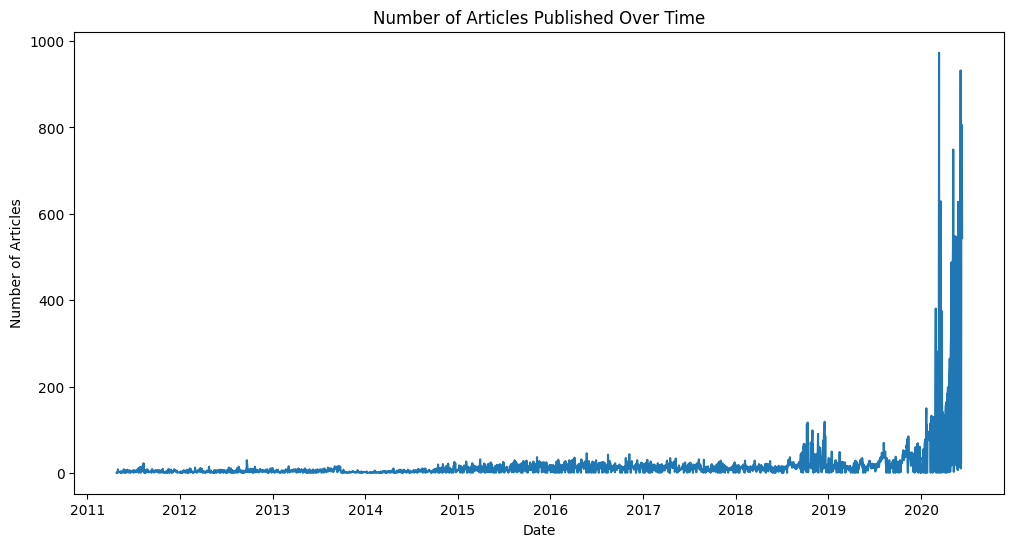

In [4]:
import matplotlib.pyplot as plt

# Assuming the descriptive_statistics function has been called already
stats = descriptive_statistics(df, 'headline', 'publisher', 'date')

# Extract the necessary data for visualization
headline_stats = stats.get('headline_stats')
articles_per_publisher = stats.get('articles_per_publisher')
trend_over_time = stats.get('trend_over_time')

# 1. Visualizing the Distribution of Headline Lengths
df['headline_length'].hist(bins=20)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Length of Headline')
plt.ylabel('Frequency')
plt.show()

# 2. Visualizing Top 10 Publishers by Number of Articles
if articles_per_publisher is not None:
    articles_per_publisher.head(10).plot(kind='bar', figsize=(10, 6))
    plt.title('Top 10 Publishers by Number of Articles')
    plt.xlabel('Publisher')
    plt.ylabel('Number of Articles')
    plt.show()
else:
    print("No publisher data available.")

# 3. Visualizing Number of Articles Published Over Time
if trend_over_time is not None:
    trend_over_time.plot(figsize=(12, 6))
    plt.title('Number of Articles Published Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.show()
else:
    print("No publication date data available.")


# Visualixation of the descriptive analysis 

In [32]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Download necessary NLTK data files
nltk.download('vader_lexicon')

# Load dataset
# Assuming the dataset is a CSV file with a 'headline' column

file_path = '../data/raw_analyst_ratings.csv'  
df = pd.read_csv(file_path)
# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Define functions for sentiment analysis
def analyze_sentiment_vader(text):
    score = vader_analyzer.polarity_scores(text)
    return score['compound']

def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis
df['vader_sentiment'] = df['headline'].apply(analyze_sentiment_vader)
df['textblob_sentiment'] = df['headline'].apply(analyze_sentiment_textblob)

# Classify sentiment
def classify_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment_class'] = df['vader_sentiment'].apply(classify_sentiment)
df['textblob_sentiment_class'] = df['textblob_sentiment'].apply(classify_sentiment)

# Topic Modeling
# Vectorize the headlines using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['headline'])

# Apply Latent Dirichlet Allocation (LDA)
num_topics = 5  # Define the number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display topics and their top words
feature_names = vectorizer.get_feature_names_out()
topics = {}
for idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:]  # Get indices of the top words for this topic
    top_words = [feature_names[i] for i in top_words_idx]
    topics[f'Topic {idx + 1}'] = top_words

# Output results
print("Sentiment Analysis Results:")
print(df[['headline', 'vader_sentiment', 'textblob_sentiment', 'vader_sentiment_class', 'textblob_sentiment_class']].head())

print("\nTopic Modeling Results:")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yonas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


KeyboardInterrupt: 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yonas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.0772}


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'sentiments' are already calculated and stored in the dataframe
df['sentiments'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0)

# 1. Histogram of Sentiment Scores
plt.figure(figsize=(10, 6))
plt.hist(df['sentiments'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Frequency')
plt.show()


# 2. Boxplot of Sentiment Scores
plt.figure(figsize=(8, 6))
plt.boxplot(df['sentiments'], vert=False)
plt.title('Boxplot of Sentiment Scores')
plt.xlabel('Sentiment Score (Compound)')
plt.show()



# 3. Bar Plot: Average Sentiment per Publisher (Top 10 publishers)
average_sentiment_per_publisher = df.groupby('publisher')['sentiments'].mean().nlargest(10)

plt.figure(figsize=(10, 6))
average_sentiment_per_publisher.plot(kind='bar', color='lightgreen')
plt.title('Average Sentiment by Top 10 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Average Sentiment Score')
plt.show()

In [22]:
def time_series_analysis(df, date_col):
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Publication frequency over time
    daily_counts = df[date_col].dt.date.value_counts().sort_index()

    # Publication frequency by hour and day of the week
    df['hour'] = df[date_col].dt.hour
    df['day_of_week'] = df[date_col].dt.day_name()
    
    hourly_counts = df['hour'].value_counts().sort_index()
    daily_counts_weekday = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

    return {
        'daily_counts': daily_counts,
        'hourly_counts': hourly_counts,
        'daily_counts_weekday': daily_counts_weekday
    }

# Call the function and display results
time_series_results = time_series_analysis(df, 'date')

# Print daily publication counts
print("Daily Publication Counts:")
print(time_series_results['daily_counts'])

# Print hourly publication counts
print("\nHourly Publication Counts:")
print(time_series_results['hourly_counts'])

# Print daily counts by day of the week
print("\nDaily Publication Counts by Day of the Week:")
print(time_series_results['daily_counts_weekday'])

Daily Publication Counts:
date
2011-04-27      1
2011-04-28      2
2011-04-29      2
2011-04-30      1
2011-05-01      1
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    544
Name: count, Length: 2528, dtype: int64

Hourly Publication Counts:
hour
0.0       67
1.0       14
2.0       57
3.0       93
4.0     1469
5.0     1829
6.0     2476
7.0     5033
8.0     5527
9.0     5965
10.0    7669
11.0    5701
12.0    5732
13.0    2710
14.0    2075
15.0    1612
16.0    3939
17.0    2800
18.0     704
19.0     227
20.0     131
21.0      82
22.0      48
23.0      27
Name: count, dtype: int64

Daily Publication Counts by Day of the Week:
day_of_week
Monday       10322
Tuesday      11002
Wednesday    11891
Thursday     12688
Friday        9381
Saturday       267
Sunday         436
Name: count, dtype: int64


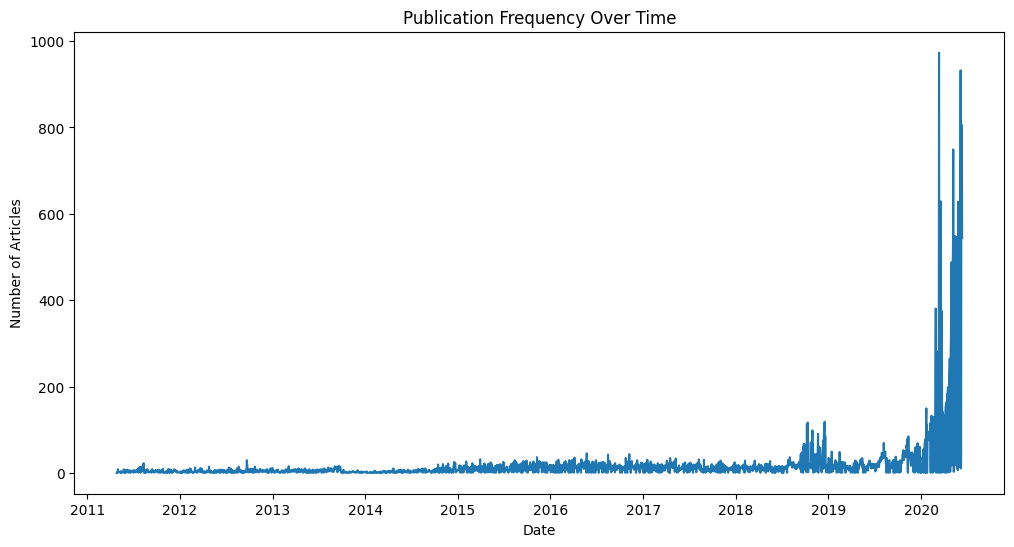

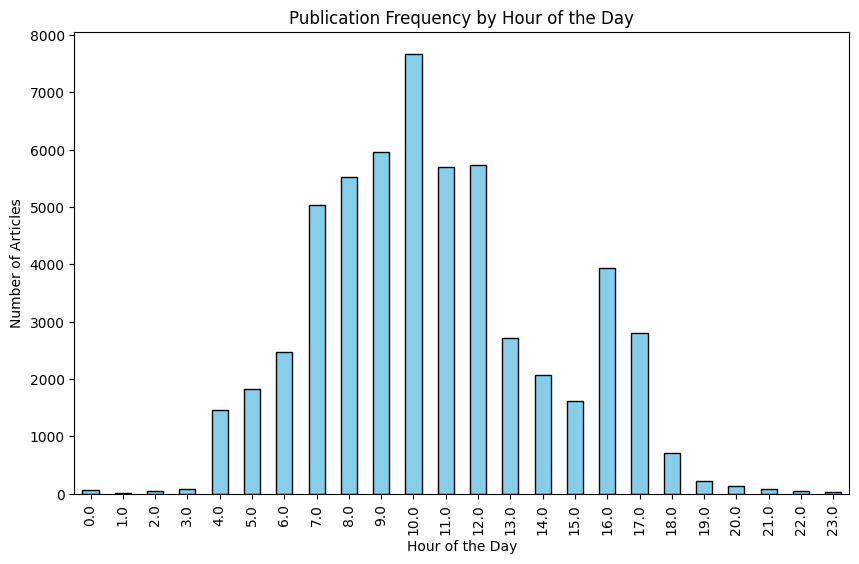

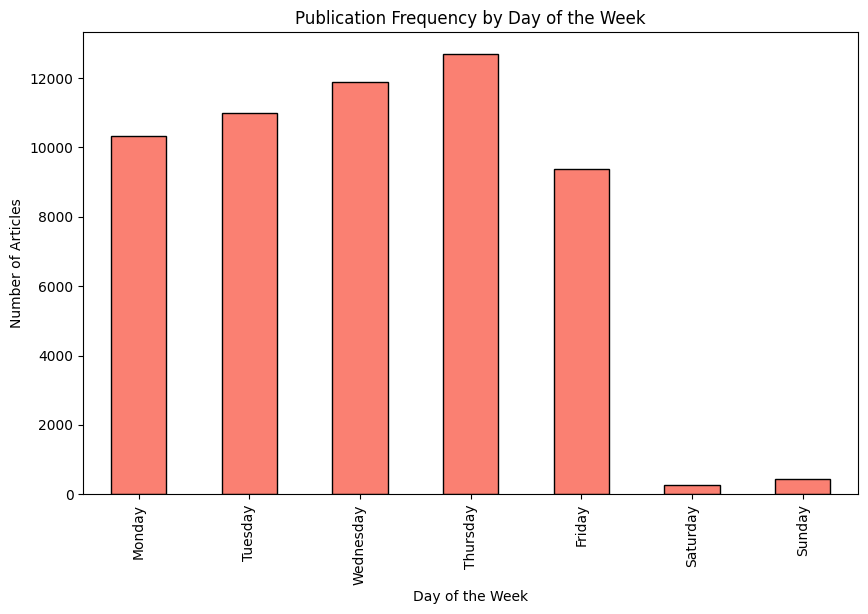

In [23]:
import matplotlib.pyplot as plt

#Daily Publication Frequency

plt.figure(figsize=(12, 6))
time_series_results['daily_counts'].plot()
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Hourly Publication Frequency

plt.figure(figsize=(10, 6))
time_series_results['hourly_counts'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Publication Frequency by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.show()

# Publication Frequency by Day of the Week:

plt.figure(figsize=(10, 6))
time_series_results['daily_counts_weekday'].plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Publication Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()



In [24]:

from urllib.parse import urlparse

def publisher_analysis(df, publisher_col):
    # Count the number of articles per publisher
    articles_per_publisher = df[publisher_col].value_counts()

    # Function to extract domain from email addresses
    def extract_domain(email):
        if isinstance(email, str) and "@" in email:
            return email.split('@')[1]
        return 'Unknown'

    # Apply domain extraction
    df['domain'] = df[publisher_col].apply(extract_domain)
    
    # Count the number of articles per domain
    domain_counts = df['domain'].value_counts()

    return articles_per_publisher, domain_counts

# Call the function and display results
publisher_counts, domain_counts = publisher_analysis(df, 'publisher')

# Print results
print("Articles per Publisher:")
print(publisher_counts)

print("\nArticles per Domain:")
print(domain_counts)


Articles per Publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64

Articles per Domain:
domain
Unknown                   1399240
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: count, dtype: int64


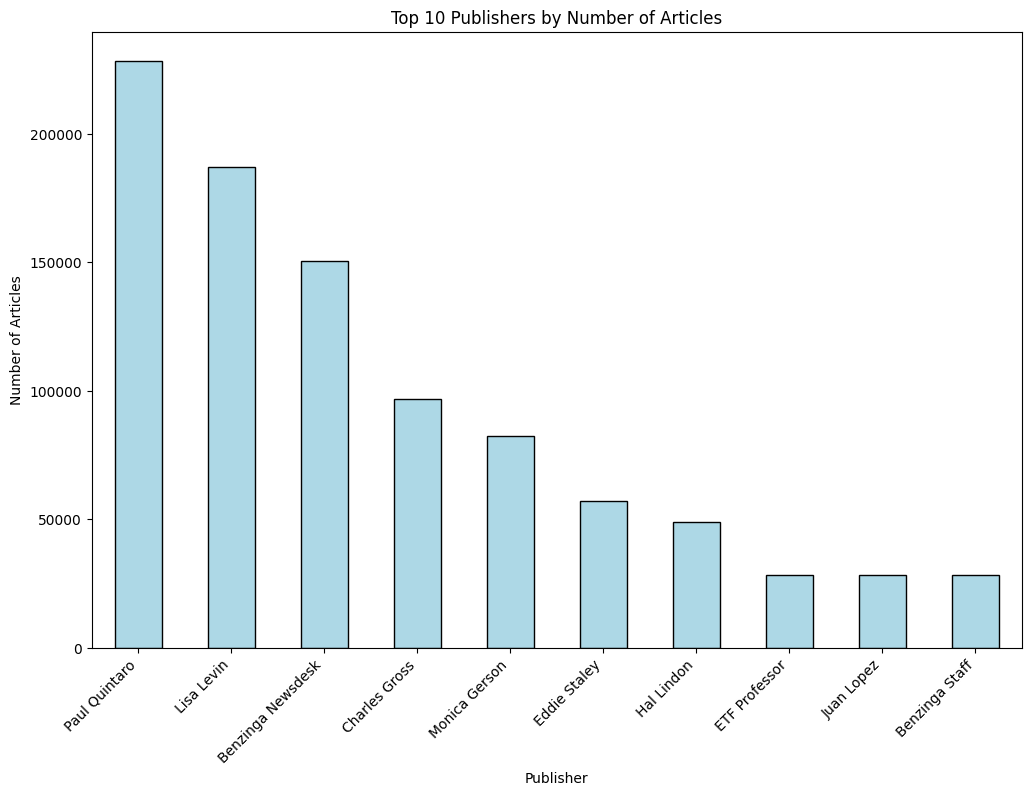

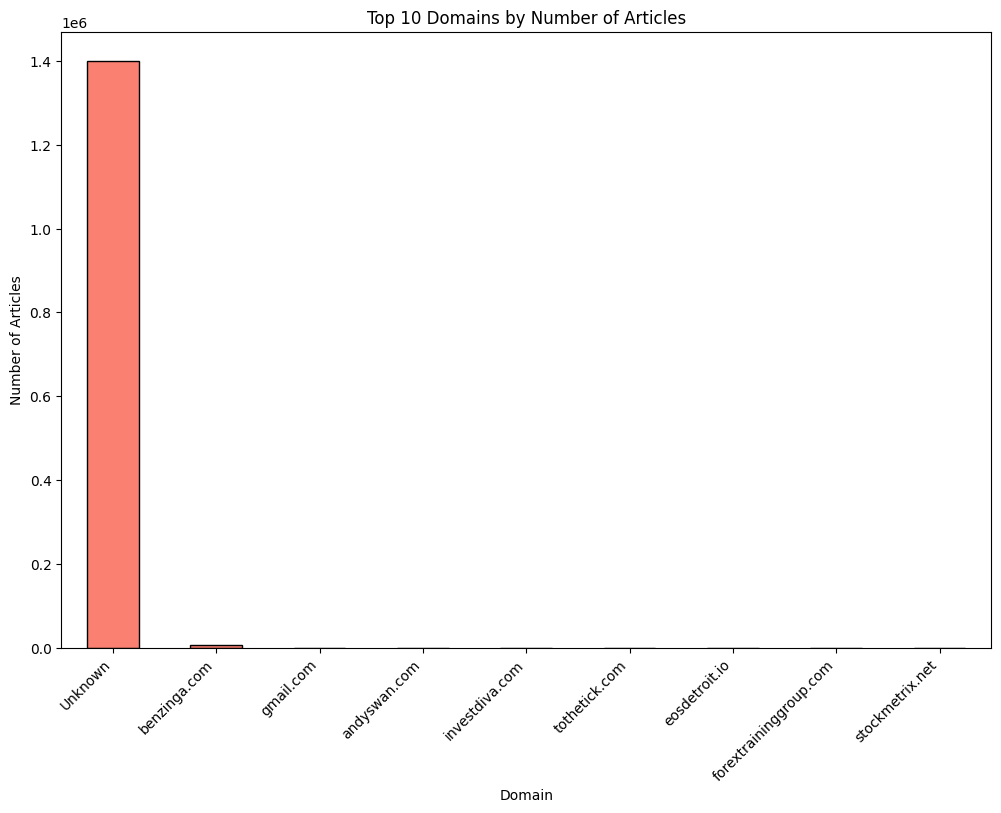

In [31]:


# a) Top Publishers by Number of Articles:
# Plot top 10 publishers

plt.figure(figsize=(12, 8))
publisher_counts.head(10).plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.show()

#Top Domains by Number of Articles:

plt.figure(figsize=(12, 8))
domain_counts.head(10).plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.show()

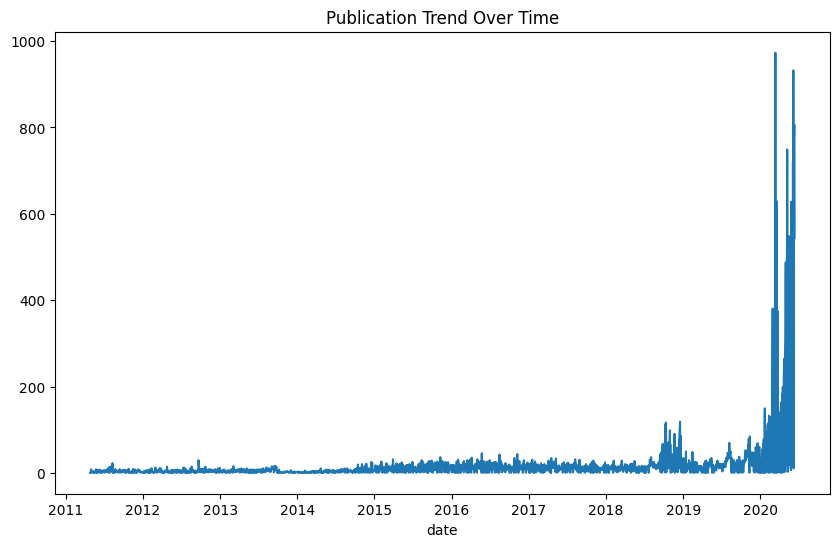

In [13]:
import matplotlib.pyplot as plt

# Plot the trend over time
stats['trend_over_time'].plot(kind='line', figsize=(10,6), title="Publication Trend Over Time")
plt.show()

# Plot publisher counts
# stats['articles_per_publisher'].plot(kind='bar', figsize=(10,6), title="Articles Per Publisher")
# plt.show()

# # Plot sentiment distribution
# sentiment_stats.hist(bins=50)
# plt.title("Sentiment Polarity Distribution")
# plt.show()